In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from PIL import Image 
from imgaug import augmenters as iaa
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix
import os
import cv2
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TensorFlow to use CPU
# Проверка, что GPU не используется:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  # Должно вывести 0

Num GPUs Available:  0


In [7]:
# Конфигурация
IMAGE_DIR = "./BCCD_Dataset-master/BCCD/JPEGImages"
ANNOTATION_DIR = "./BCCD_Dataset-master/BCCD/Annotations"
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
NUM_BOXES = 50
NUM_CLASSES = 3

In [9]:
# Парсер XML (без изменений)
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes, classes = [], []
    for obj in root.findall('object'):
        box = obj.find('bndbox')
        coords = [float(box.find(tag).text) for tag in ['xmin', 'ymin', 'xmax', 'ymax']]
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)
        boxes.append([coords[0]/width, coords[1]/height, coords[2]/width, coords[3]/height])
        classes.append(obj.find('name').text)
    return boxes, classes

In [11]:
# Генератор данных (финальная версия)
class BloodCellGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, xml_dir, batch_size, img_size):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.xml_dir = xml_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.class_map = {'RBC': 0, 'WBC': 1, 'Platelets': 2}
        
    def __len__(self):
        return len(self.image_paths) // self.batch_size
    
    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx*self.batch_size:(idx+1)*self.batch_size]
        images = np.zeros((self.batch_size, *self.img_size, 3), dtype=np.float32)
        boxes = np.zeros((self.batch_size, NUM_BOXES, 4), dtype=np.float32)
        labels = np.zeros((self.batch_size, NUM_BOXES, NUM_CLASSES), dtype=np.float32)
        
        for i, img_path in enumerate(batch_paths):
            img = Image.open(img_path).resize(self.img_size)
            xml_path = os.path.join(self.xml_dir, os.path.basename(img_path).replace('.jpg', '.xml'))
            
            # Загрузка данных
            images[i] = np.array(img) / 255.0
            box_coords, class_names = parse_xml(xml_path)
            class_ids = [self.class_map[name] for name in class_names]
            
            # Фикс для пустых аннотаций
            num_valid = min(len(box_coords), NUM_BOXES)
            boxes[i, :num_valid] = box_coords[:num_valid]
            labels[i, np.arange(num_valid), class_ids[:num_valid]] = 1.0
                
        return images, (boxes, labels)


In [13]:
# Модель 
def create_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    
    x = layers.Conv2D(16, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    
    features = layers.GlobalAveragePooling2D()(x)
    box_output = layers.Dense(NUM_BOXES * 4)(features)
    box_output = layers.Reshape((NUM_BOXES, 4))(box_output)
    
    cls_output = layers.Dense(NUM_BOXES * NUM_CLASSES, activation='softmax')(features)
    cls_output = layers.Reshape((NUM_BOXES, NUM_CLASSES))(cls_output)
    
    return tf.keras.Model(inputs, [box_output, cls_output])

In [46]:
# Инициализация
model = create_model()
model.compile(optimizer='adam', loss=['mse', 'categorical_crossentropy'])

# Проверка данных
train_gen = BloodCellGenerator(IMAGE_DIR, ANNOTATION_DIR, BATCH_SIZE, IMG_SIZE)
images, (boxes, labels) = train_gen[0]

print("Проверка форм данных:")
print(f"Изображения: {images.shape}")  # (8, 224, 224, 3)
print(f"Боксы: {boxes.shape}")         # (8, 50, 4)
print(f"Классы: {labels.shape}")       # (8, 50, 3)

# Обучение
model.fit(train_gen, epochs=5)

Проверка форм данных:
Изображения: (8, 224, 224, 3)
Боксы: (8, 50, 4)
Классы: (8, 50, 3)
Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - loss: 0.3151 - reshape_2_loss: 0.0785 - reshape_3_loss: 0.2366
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - loss: 0.1580 - reshape_2_loss: 0.0334 - reshape_3_loss: 0.1246
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 0.1535 - reshape_2_loss: 0.0317 - reshape_3_loss: 0.1218
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 0.1484 - reshape_2_loss: 0.0321 - reshape_3_loss: 0.1163
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - loss: 0.1512 - reshape_2_loss: 0.0318 - reshape_3_loss: 0.1194


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


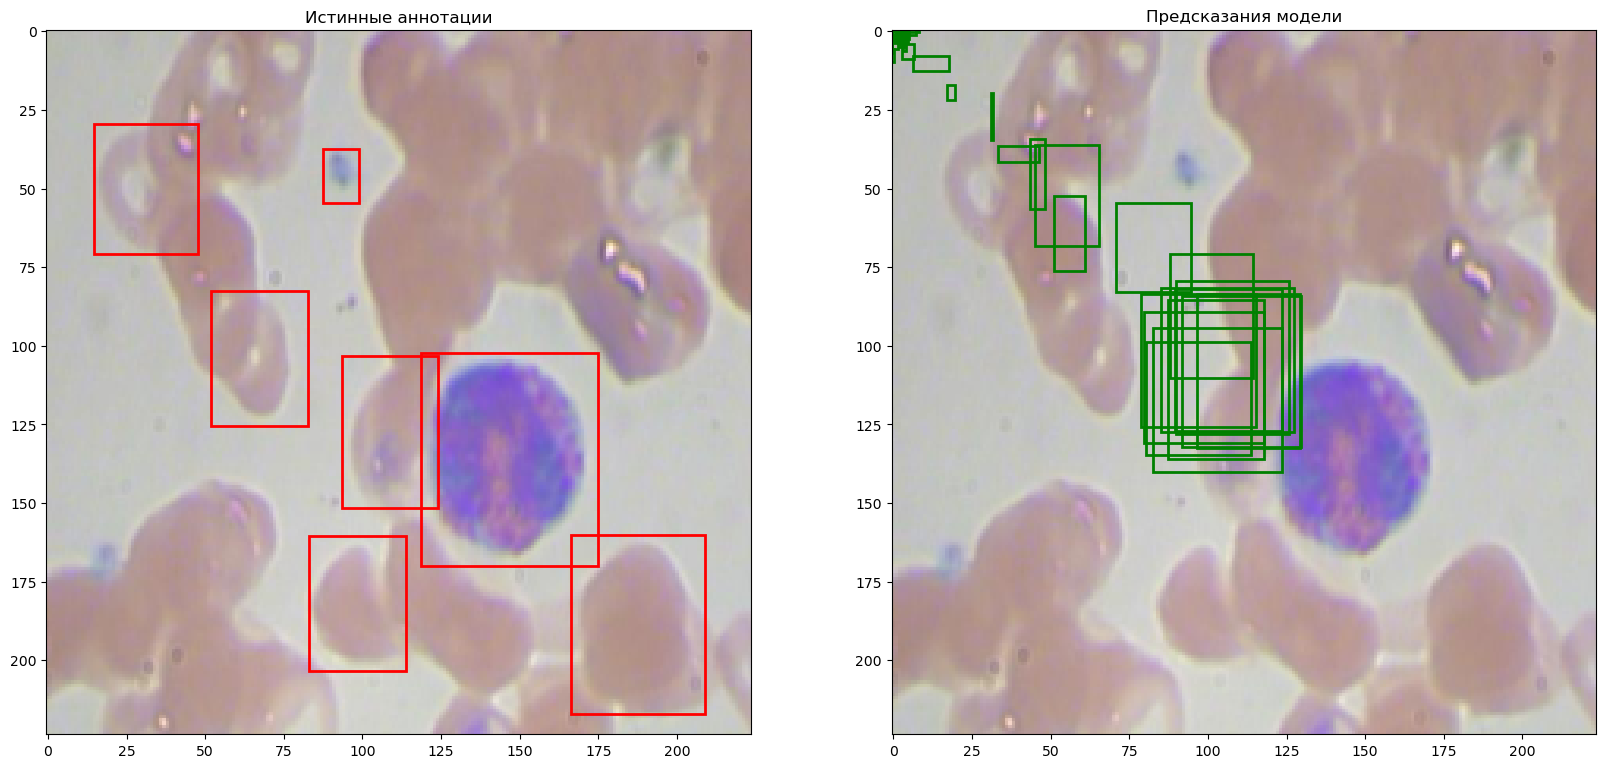

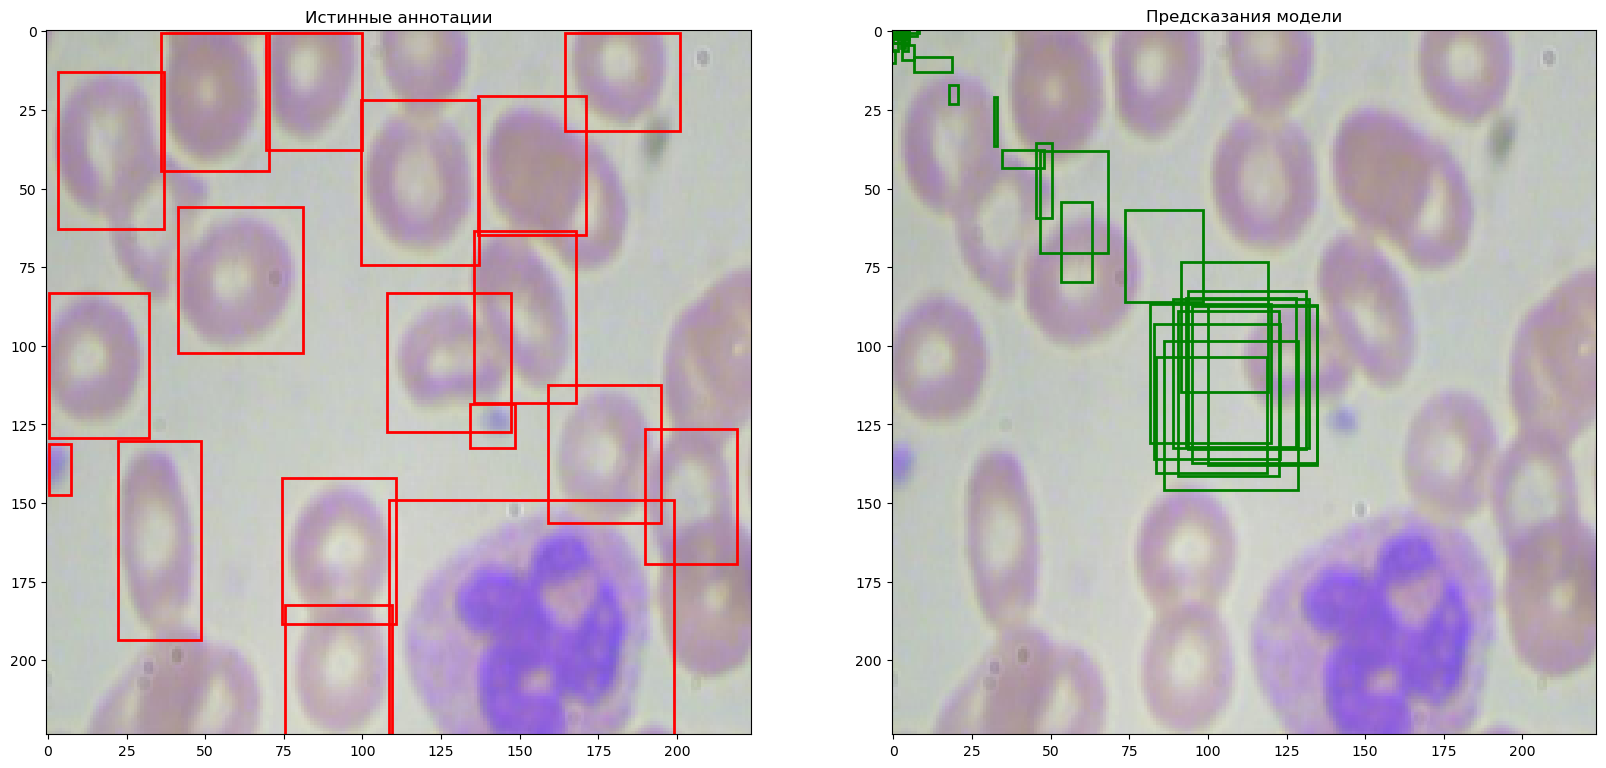

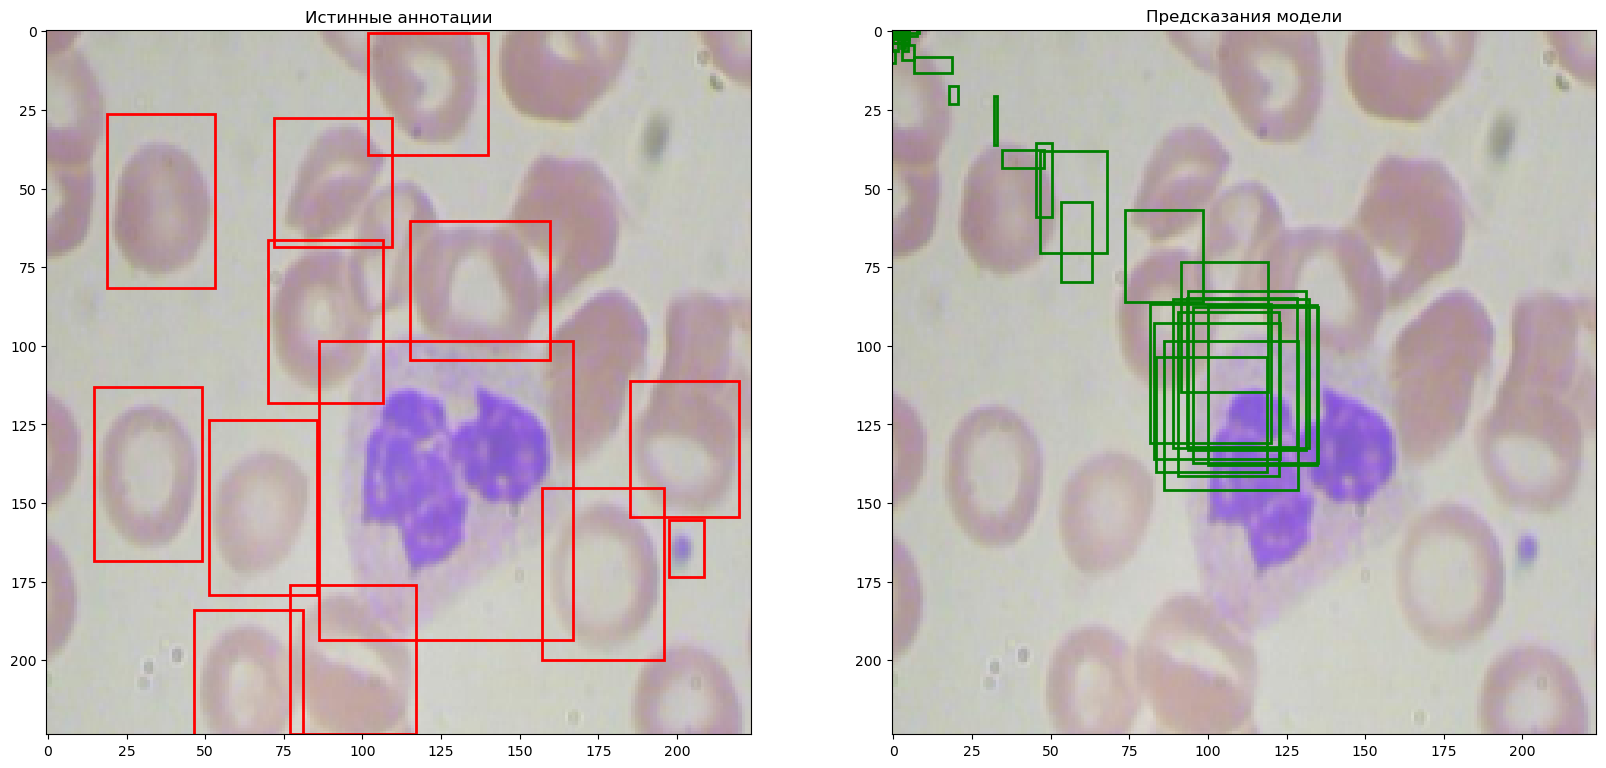

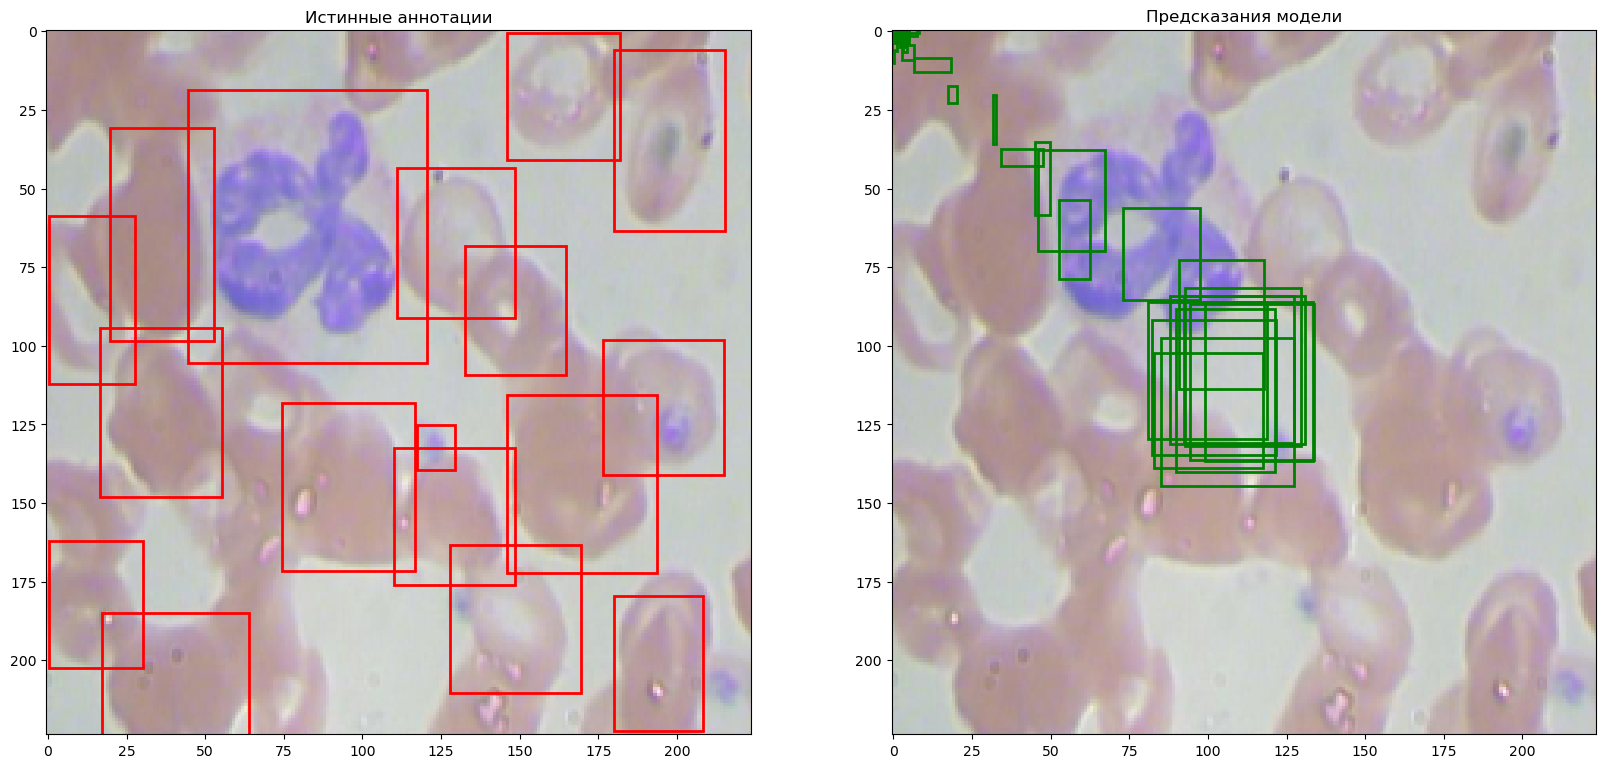

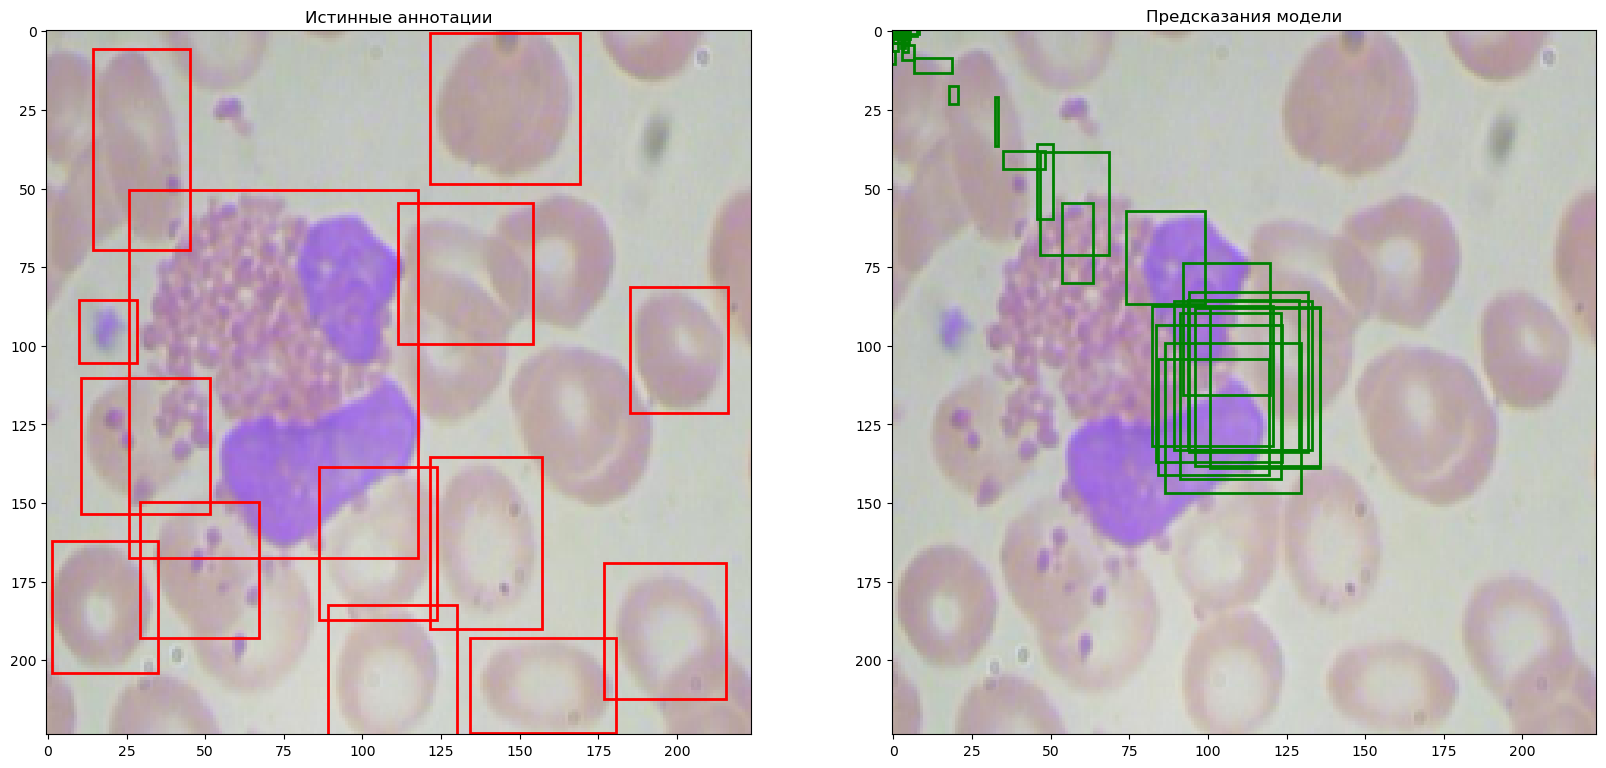

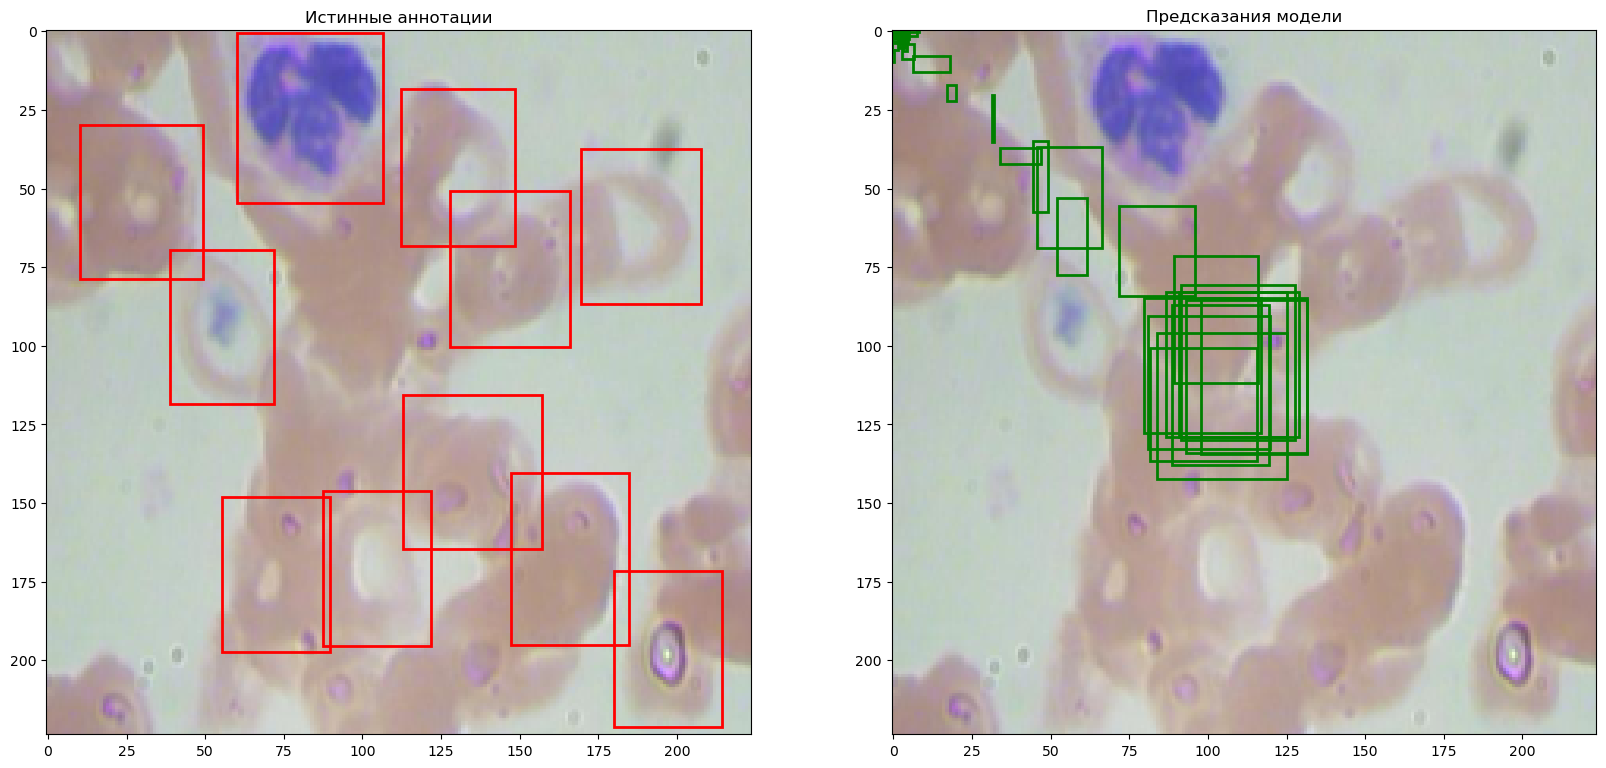

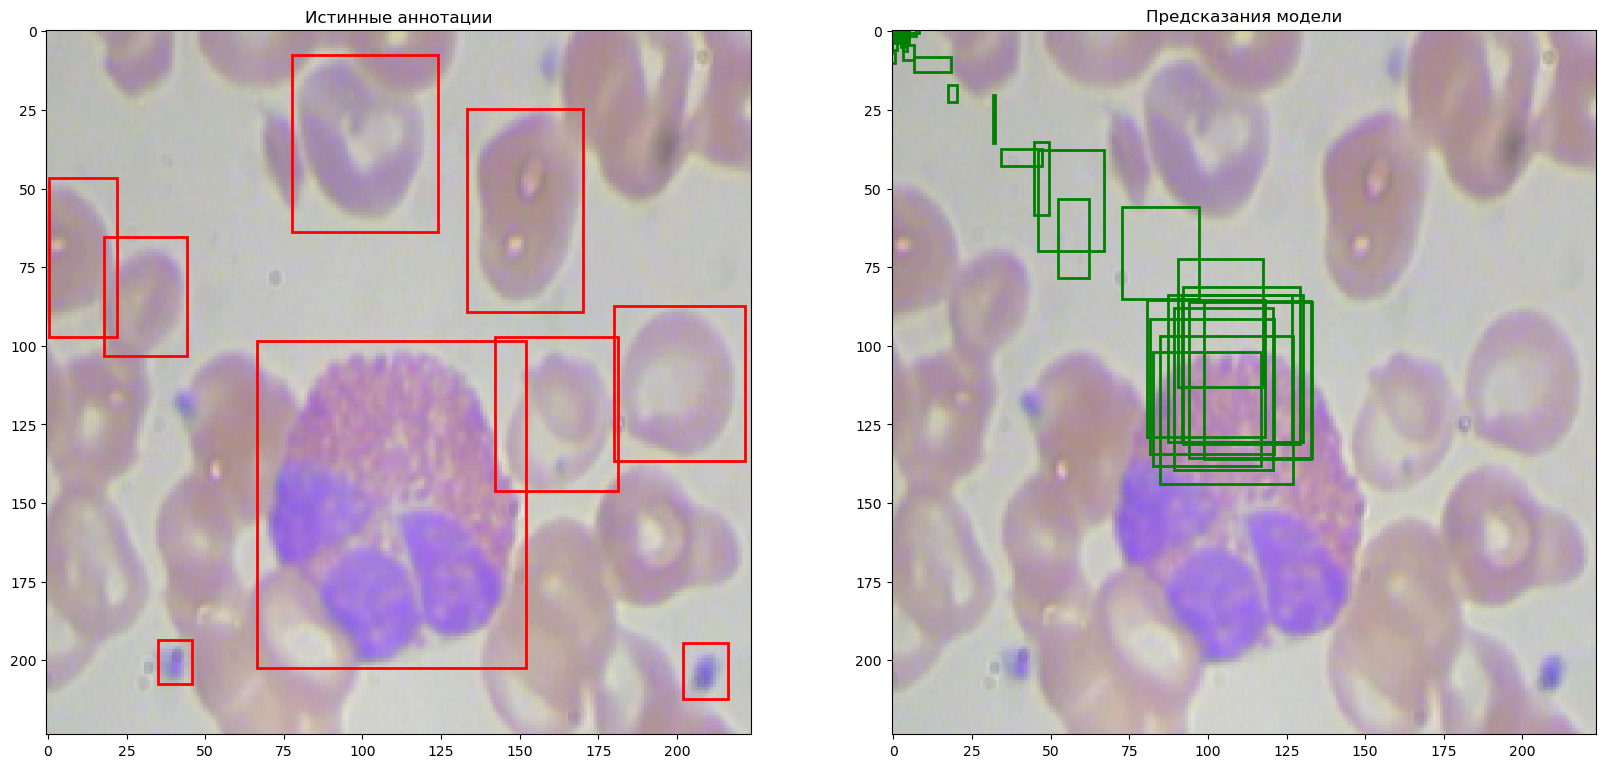

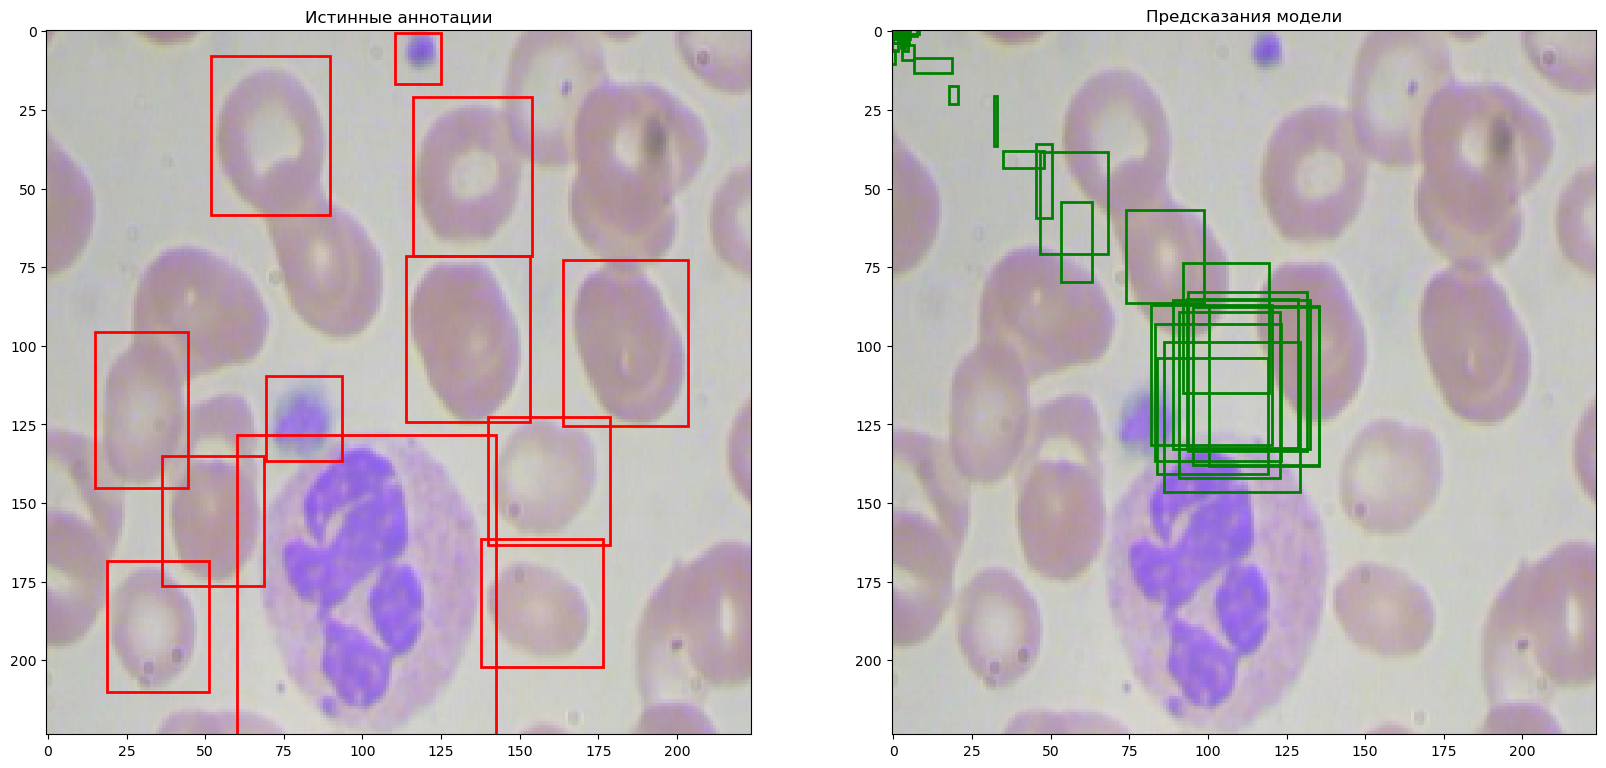

In [48]:
def visualize_predictions(model, generator, idx=0):
    # Получение данных из генератора
    images, (true_boxes, true_labels) = generator[idx]
    
    # Предсказание модели
    pred_boxes, pred_labels = model.predict(images)
    
    # Визуализация для каждого изображения в батче
    for i in range(len(images)):
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        
        # Истинные аннотации
        ax[0].imshow(images[i])
        ax[0].set_title("Истинные аннотации")
        for box in true_boxes[i]:
            if np.sum(box) > 0:  # Игнорируем нулевые боксы
                rect = patches.Rectangle(
                    (box[0]*IMG_SIZE[1], box[1]*IMG_SIZE[0]),
                    (box[2]-box[0])*IMG_SIZE[1], 
                    (box[3]-box[1])*IMG_SIZE[0],
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                ax[0].add_patch(rect)
        
        # Предсказания модели
        ax[1].imshow(images[i])
        ax[1].set_title("Предсказания модели")
        for box in pred_boxes[i]:
            if np.sum(box) > 0:  # Игнорируем нулевые боксы
                rect = patches.Rectangle(
                    (box[0]*IMG_SIZE[1], box[1]*IMG_SIZE[0]),
                    (box[2]-box[0])*IMG_SIZE[1], 
                    (box[3]-box[1])*IMG_SIZE[0],
                    linewidth=2, edgecolor='g', facecolor='none'
                )
                ax[1].add_patch(rect)
        
        plt.show()

# Пример использования
visualize_predictions(model, train_gen, idx=0)

In [49]:
def calculate_iou(boxA, boxB):
    # Вычисление Intersection over Union
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    inter_area = max(0, xB - xA) * max(0, yB - yA)
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    return inter_area / float(boxA_area + boxB_area - inter_area)

def evaluate_model(model, generator):
    iou_scores = []
    class_accuracies = []
    
    for idx in range(len(generator)):
        images, (true_boxes, true_labels) = generator[idx]
        pred_boxes, pred_labels = model.predict(images)
        
        for i in range(len(images)):
            # Для каждого изображения
            for true_box, pred_box in zip(true_boxes[i], pred_boxes[i]):
                if np.sum(true_box) > 0 and np.sum(pred_box) > 0:
                    iou_scores.append(calculate_iou(true_box, pred_box))
            
            # Точность классификации
            true_class = np.argmax(true_labels[i], axis=-1)
            pred_class = np.argmax(pred_labels[i], axis=-1)
            valid_mask = np.sum(true_labels[i], axis=-1) > 0
            class_accuracies.extend((true_class[valid_mask] == pred_class[valid_mask]).tolist())
    
    print(f"Средний IoU: {np.mean(iou_scores):.2f}")
    print(f"Точность классификации: {np.mean(class_accuracies):.2%}")

# Запуск оценки
evaluate_model(model, train_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━

In [51]:
# Предсказания модели
pred_boxes, pred_labels = model.predict(images)

# Вычисление IoU для всех пар боксов
iou_scores = []
for i in range(len(images)):
    for true_box, pred_box in zip(true_boxes[i], pred_boxes[i]):
        if np.sum(true_box) > 0 and np.sum(pred_box) > 0:  # Игнорируем пустые боксы
            iou_scores.append(calculate_iou(true_box, pred_box))

# Анализ IoU по классам
class_names = ['RBC', 'WBC', 'Platelets']
for class_id in range(NUM_CLASSES):
    class_iou = []
    for i in range(len(images)):
        for j in range(NUM_BOXES):
            if np.sum(true_boxes[i][j]) > 0 and true_labels[i][j][class_id] == 1:
                # Проверяем, есть ли соответствующий IoU
                if len(iou_scores) > i * NUM_BOXES + j:
                    class_iou.append(iou_scores[i * NUM_BOXES + j])
    
    # Вывод среднего IoU для текущего класса
    if len(class_iou) > 0:
        print(f"{class_names[class_id]} - Средний IoU: {np.mean(class_iou):.2f}")
    else:
        print(f"{class_names[class_id]} - Нет данных для расчета IoU")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
RBC - Средний IoU: 0.02
WBC - Средний IoU: 0.00
Platelets - Средний IoU: 0.00


In [52]:
# Пример проверки пар боксов
for i in range(len(images)):
    for j in range(NUM_BOXES):
        true_box = true_boxes[i][j]
        pred_box = pred_boxes[i][j]
        
        if np.sum(true_box) > 0 and np.sum(pred_box) > 0:
            iou = calculate_iou(true_box, pred_box)
            print(f"Изображение {i}, бокс {j}:")
            print(f"Истинный бокс: {true_box}")
            print(f"Предсказанный бокс: {pred_box}")
            print(f"IoU: {iou}")

Изображение 0, бокс 0:
Истинный бокс: [0.3703125  0.71666664 0.5078125  0.90833336]
Предсказанный бокс: [0.35584533 0.39781395 0.526663   0.5839753 ]
IoU: 0.0
Изображение 0, бокс 1:
Истинный бокс: [0.23125    0.36875    0.36875    0.56041664]
Предсказанный бокс: [0.400306  0.3652473 0.5516299 0.5673803]
IoU: 0.0
Изображение 0, бокс 2:
Истинный бокс: [0.7421875  0.71458334 0.9328125  0.96875   ]
Предсказанный бокс: [0.43051904 0.37326834 0.577854   0.59129274]
IoU: 0.0
Изображение 0, бокс 3:
Истинный бокс: [0.4171875  0.46041667 0.553125   0.6770833 ]
Предсказанный бокс: [0.4089769  0.37576577 0.57870114 0.5896906 ]
IoU: 0.3646782777884032
Изображение 0, бокс 4:
Истинный бокс: [0.065625   0.13125    0.2125     0.31666666]
Предсказанный бокс: [0.39034358 0.38200834 0.5256482  0.6063683 ]
IoU: 0.0
Изображение 0, бокс 5:
Истинный бокс: [0.5296875 0.45625   0.78125   0.7583333]
Предсказанный бокс: [0.35121357 0.37293294 0.5145844  0.5614146 ]
IoU: 0.0
Изображение 0, бокс 6:
Истинный бокс: [

Пример истинного бокса: [0.3703125  0.71666664 0.5078125  0.90833336]
Пример предсказанного бокса: [0.35584533 0.39781395 0.526663   0.5839753 ]


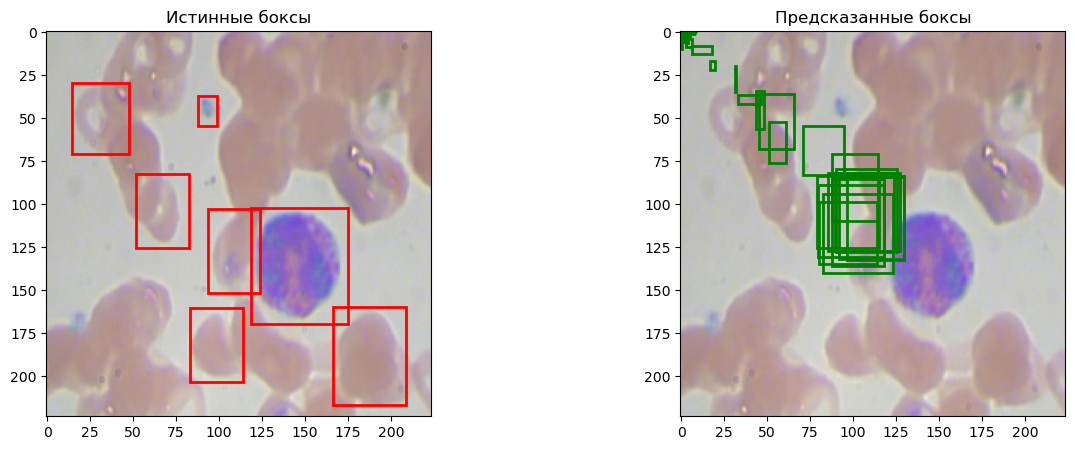

In [53]:
def visualize_predictions(image, true_boxes, pred_boxes, img_size=(224, 224)):
    plt.figure(figsize=(15, 5))
    
    # Истинные боксы (красные)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    for box in true_boxes:
        if np.sum(box) > 0:  # Игнорируем пустые боксы
            # Координаты в формате [xmin, ymin, xmax, ymax] (нормализованные)
            x1, y1, x2, y2 = box
            # Денормализация координат
            x1 *= img_size[1]  # Ширина изображения
            y1 *= img_size[0]  # Высота изображения
            x2 *= img_size[1]
            y2 *= img_size[0]
            plt.gca().add_patch(plt.Rectangle(
                (x1, y1), x2-x1, y2-y1, 
                linewidth=2, edgecolor='r', facecolor='none'
            ))
    plt.title("Истинные боксы")

    # Предсказанные боксы (зеленые)
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    for box in pred_boxes:
        if np.sum(box) > 0:  # Игнорируем пустые боксы
            x1, y1, x2, y2 = box
            x1 *= img_size[1]
            y1 *= img_size[0]
            x2 *= img_size[1]
            y2 *= img_size[0]
            plt.gca().add_patch(plt.Rectangle(
                (x1, y1), x2-x1, y2-y1, 
                linewidth=2, edgecolor='g', facecolor='none'
            ))
    plt.title("Предсказанные боксы")
    
    plt.show()

# Пример использования с проверкой данных
print("Пример истинного бокса:", true_boxes[0][0])  # Должно быть [xmin, ymin, xmax, ymax]
print("Пример предсказанного бокса:", pred_boxes[0][0])
visualize_predictions(images[0], true_boxes[0], pred_boxes[0], IMG_SIZE)